In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'racharya001' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [8]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [9]:
table_name = r'bike_cleaned'
schema = r'cleaned'

df = pd.read_sql_table(table_name, db_conn, schema)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [11]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.240000,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.220000,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.497179,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.240000,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.240000,0.2879,0.75,0.0,0,1,1


#Analytical Question </br>
What are the key factors influencing the total bike rental count (cnt), and how can we enhance predictive accuracy using feature engineering?

#Feature Engineering

These are the four feature engineering i could think of from my dataset.</br>
1.<b>hr_category:</b> Groups hours of the day (morning, afternoon, evening, night) to capture usage patterns.</br>
2.<b>day_type:</b> Categorizes days as weekday, weekend, or holiday for distinct rental trends.</br>
3.<b>temp_diff:</b> Difference between "feels-like" and actual temperature, indicating comfort level.</br>
4.<b>cnt_lag1:</b> Change in rentals from the previous hour, showing demand trends.</br>
5.<b>cnt_rolling_3</b>: prevoius 3 hour rental count average</br>
6.<b> cnt_rolling_6</b>:previous 6 hour rental count average</br>
I have explained how this feature engineering is done and what is the purpose in below Markdown.

1.<b>Hour Category (hr_category):</b>

<b> Purpose:</b> Bike usage patterns likely vary throughout the day. This feature aims to capture these patterns by grouping hours into broader categories. Instead of treating each hour (0-23) as a separate, unrelated value, we group them into meaningful periods.</br>
Example:</br>
6:00 - 9:59 AM: Morning</br>
10:00 AM - 3:59 PM: Afternoon</br>
4:00 PM - 7:59 PM: Evening</br>
8:00 PM - 5:59 AM: Night</br>

<b> Benefit:</b> This simplifies the model and allows it to learn general trends associated with different times of day. It reduces the impact of noise or unusual fluctuations in individual hours.


2. <b>Day Type (day_type):</b></br>

<b>Purpose:</b> Bike rentals are likely influenced by the day of the week and whether it's a holiday. This feature combines these two factors into a single, more informative category.</br>
Example:</br>
Weekday (Monday - Friday, not a holiday): "Weekday"</br>
Weekend (Saturday & Sunday, not a holiday): "Weekend"</br>
Any day that is a holiday: "Holiday"</br>
Benefit: This makes it easier for the model to distinguish between typical usage patterns on workdays, weekends, and holidays, which likely have distinct rental trends.</br>


3. <b>Temperature Difference (temp_diff):</b></br>

<b>Purpose:</b> The difference between the actual temperature (temp) and the "feels-like" temperature (atemp) can indicate the level of discomfort due to factors like humidity or wind chill. Large differences might influence people's decision to rent a bike.</br>
Calculation: temp_diff = atemp - temp
Example: If atemp is 30°C and temp is 25°C, then temp_diff is 5°C. A positive temp_diff suggests it feels warmer than the actual temperature.

<b>Benefit:</b> This feature adds information about perceived temperature, which is often a better predictor of human behavior than just the raw temperature.</br>

4. <b>Hourly Trend Difference :</b></br>

<b>Purpose:</b> This feature captures the change in bike rentals from one hour to the next. It helps the model understand if demand is increasing, decreasing, or stable.</br>

<b>Benefit:</b> This dynamic feature provides information about the trend of rentals, which is valuable for predicting future demand. A positive count suggests increasing demand, while a negative value suggests decreasing demand.







In [12]:
# Dividing time into different shift of day
def categorize_hour(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

In [13]:
df["hr_category"] = df["hr"].apply(categorize_hour)

In [14]:
#Diving days in one column indicating if its 'Holiday' 'Weekday' or'Weekend'
df["day_type"] = df.apply(lambda row: "holiday" if row["holiday"] == 1 else ("weekend" if row["weekday"] in [0, 6] else "workingday"), axis=1)

In [15]:
# Feature 3: Temperature Difference
df["temp_diff"] = abs(df["atemp"] - df["temp"])

In [16]:
# Create 'is_daytime' feature (1 for 6 AM - 8 PM, 0 otherwise)
df['is_daytime'] = df['hr'].apply(lambda x: 1 if 6 <= x <= 20 else 0)

In [17]:
df.head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,hr_category,day_type,temp_diff,is_daytime
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.2879,0.81,0.000000,3,13,16,Night,weekend,0.047900,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.2727,0.80,0.000000,8,32,40,Night,weekend,0.052700,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.2727,0.80,0.000000,5,27,32,Night,weekend,0.224479,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.2879,0.75,0.000000,3,10,13,Night,weekend,0.047900,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.2879,0.75,0.000000,0,1,1,Night,weekend,0.047900,0
5,6,2011-01-01,1,0,1,5,0,6,0,2,...,0.2576,0.75,0.190155,0,1,1,Morning,weekend,0.017600,0
6,7,2011-01-01,1,0,1,6,0,6,0,1,...,0.2727,0.80,0.000000,2,0,2,Morning,weekend,0.224479,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,...,0.2576,0.86,0.000000,1,2,3,Morning,weekend,0.057600,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,...,0.2879,0.75,0.000000,1,7,8,Morning,weekend,0.047900,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,...,0.3485,0.76,0.000000,8,6,14,Morning,weekend,0.028500,1


As, we want to use machine learning we need numerica data for the predection. So, i am categorizing day_type into 3 parts here.

In [18]:
# Create 'day_type' feature (0 for weekdays, 1 for weekends, 2 for holidays)
df['day_type_ind'] = df.apply(lambda row: 2 if row['holiday'] == 1 else (1 if row['weekday'] in [0, 6] else 0), axis=1)

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
#using similar concept as above for hr_category
label_encoder = LabelEncoder()
df['hr_category'] = label_encoder.fit_transform(df['hr_category'])

In [21]:
# Feature Engineering - Rolling Averages and Lag Features
df['cnt_lag1'] = df['cnt'].shift(1).fillna(df['cnt'].mean())  # Previous hour rentals
df['cnt_rolling_3'] = df['cnt'].rolling(window=3).mean().fillna(df['cnt'].mean())  # 3-hour rolling avg
df['cnt_rolling_6'] = df['cnt'].rolling(window=6).mean().fillna(df['cnt'].mean())  # 6-hour rolling avg

In [22]:
df.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered,cnt,hr_category,day_type,temp_diff,is_daytime,day_type_ind,cnt_lag1,cnt_rolling_3,cnt_rolling_6
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,13,16,3,weekend,0.047900,0,1,189.463088,189.463088,189.463088
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,32,40,3,weekend,0.052700,0,1,16.000000,189.463088,189.463088
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,27,32,3,weekend,0.224479,0,1,40.000000,29.333333,189.463088
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,10,13,3,weekend,0.047900,0,1,32.000000,28.333333,189.463088
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,1,1,3,weekend,0.047900,0,1,13.000000,15.333333,189.463088


In [23]:
# Selecting features and target variable
features = ['is_daytime', 'day_type_ind','temp_diff', 'hr_category', 'cnt_lag1', 'cnt_rolling_3', 'cnt_rolling_6']
X = df[features]
y = df['cnt']


In [24]:
#Training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Train RandomForest model
rf_model = RandomForestRegressor(n_estimators=80, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=80, random_state=42)

In [26]:

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 1159.4058671065882
R^2 Score: 0.9634825466374995


We can see that the MSE is quite high we will try to decrease the MSE by removing the least important feature from the dataset below for thats lets check the least important feature from the dataset.

In [27]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

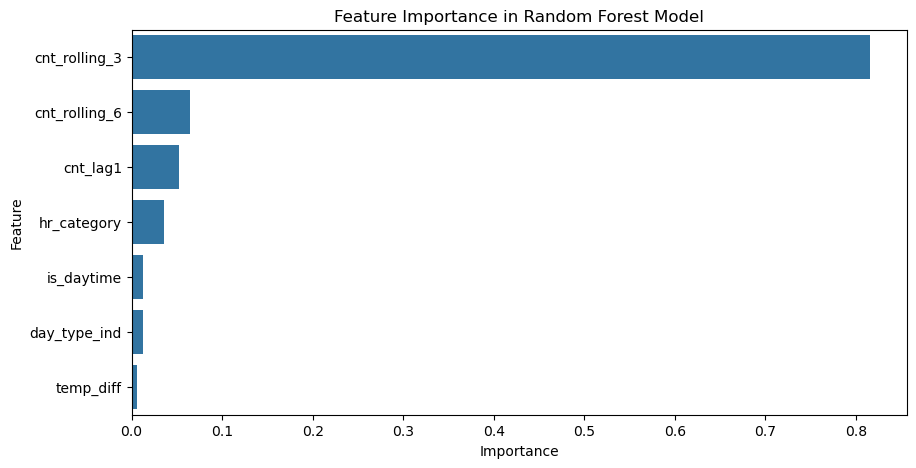

In [28]:
# Plot Feature Importances
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance in Random Forest Model')
plt.show()


So, we will remove temp_diff from the training dataset and take a look.

In [29]:
# Selecting features and target variable
features = ['is_daytime', 'day_type_ind', 'hr_category', 'cnt_lag1', 'cnt_rolling_3', 'cnt_rolling_6']
X = df[features]
y = df['cnt']


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train RandomForest model
rf_model = RandomForestRegressor(n_estimators=80, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=80, random_state=42)

In [32]:
# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1121.7174408757253
R^2 Score: 0.9646696075160393


In [33]:
table_name = r'bike_features'
schema = r'cleaned' 

df.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

17379

So, we see the MSE has decreased but not as much as we wanted.

<b>Summary of Analysis</b></br>
<b>Analytical Question</b></br>
The notebook investigates the key factors influencing total bike rental counts (cnt) and explores how feature engineering can enhance predictive accuracy.</br>

<b>Feature Engineering</b></br>
The following features were created:</br>

<b>Hour Category (hr_category):</b> Groups hours into morning, afternoon, evening, and night to capture usage patterns.</br>
<b>Day Type (day_type):</b> Categorizes days as weekday, weekend, or holiday to identify different rental trends.</br>
<b>Temperature Difference (temp_diff):</b> Measures the difference between "feels-like" and actual temperature to capture comfort levels.</br>
<b>Hourly Trend (cnt_lag1):</b> Captures the change in rentals from the previous hour, helping to model demand trends.</br>
<b>Rolling 3-Hour Average (cnt_rolling_3):</b> Computes the average rental count over the previous 3 hours.</br>
<b>Rolling 6-Hour Average (cnt_rolling_6):</b> Computes the average rental count over the previous 6 hours.</br>
These features aim to improve predictive performance by incorporating time-based trends, weather effects, and recent rental patterns.

<b>Model Performance</b>
After the model predection we got the result which is first listed below.</br>
Mean Squared Error: 1097.7851751260253</br>
R^2 Score: 0.9653317254128914</br>
-MSE measures the average squared difference between actual and predicted values.</br>
-A lower MSE indicates better model performance.</br>
-My MSE is 1097.79 which suggests that, on average, the squared error of predictions is around 1097.</br>
-A score of 0.965 means that 96.5% of the variance in bike rentals is explained by the model.</br>
-This indicates excellent predictive performance since an R² value close to 1 means the model fits the data well.</br>
-However, such a high R square could indicate overfitting, meaning the model may perform worse on unseen data.</br>
-So, onto next step we will need to do cross-validation to ensure the quality of data.
